**A brief overview of <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>**:

<span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> is a open-source, light-weight code for **X-ray spectral shifting and stacking**. 

Given the **redshift** of each spectrum in a list, <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> will first shift these spectra *(PHA, counts vs. output energy (channel))* from observed-frame to rest-frame, and then sum them together. The response matrix files *(RMF, the probability that a photon with input energy $E_1$ will be detected with an output energy $E_2$)* and ancillary response files *(ARF, effective area vs. input energy)* are shifted and stacked in a similar way to the spectrum. <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> also supports correction of Galactic absorption, if an additional **NH** value (in units of 1 $\text{cm}^{-2}$) for each spectrum is given.

In this demo, a preliminary example is provided (stacking powerlaws) to help you get started with <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>. Running <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> is essentially convenient: you simply need to specify where the spectral files are stored, along with the redshift and Galactic absorption (if possible). After that, you can run <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> in one go.

In [1]:
# the main module
from Xstack import Xstack
from Xstack.Xstack import XstackRunner, default_nh_file

# some miscellaneous packages for plotting, and generating fake spectra
from Xstack.simulate_spec import make_fkspec
from Xstack.misc import make_grpflg,rebin_pi,rebin_arf
from Xstack.shift_arf import align_arf

# the usual packages
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from tqdm import tqdm
import os
from joblib import Parallel,delayed
import subprocess
import warnings

# **1. Primary example: stacking single powerlaws**
***with different redshift, photon indices, and luminosities***

I have already generated 200 powerlaws with different redshifts ($0.3<z<2.0$), rest-frame 0.5-10 keV luminosities ($44.5<\log L_\text{0.5-10}<45.5$) and photon indices ($1.9<\Gamma<2.1$), based on the ARF, RMF, and background information of an arbitary *eROSITA* observation (eFEDS ID: 00007). These spectral files are stored in `./data/po/po_spec`. The redshift of each source is recorded as `./data/po/po_spec/{srcid}_po.pi.z`

Now let us walk through the basic procedures of running <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>.

## **Step 1**: Initialize <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>

You will first tell <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> where your spectral files are stored. The block below fetches some basic data.

In [3]:
# fetch some basic data (they have already been generated)
pifile_lst = []
bkgpifile_lst = []
rmffile_lst = []
arffile_lst = []
z_lst = []

for i in range(200):
    pifile = './data/po/po_spec/%05d_po.pi'%i
    with fits.open(pifile) as hdu:
        head = hdu[1].header
    path = os.path.dirname(pifile)
    bkgpifile = os.path.join(path,head['BACKFILE'])
    rmffile = os.path.join(path,head['RESPFILE'])
    arffile = os.path.join(path,head['ANCRFILE'])
    zfile = os.path.join(path,head['ZFILE'])        # file storing redshift
    with open(zfile,'r') as f:
        z = f.readlines()
    z = float(z[0].rstrip())

    pifile_lst.append(pifile)
    bkgpifile_lst.append(bkgpifile)
    rmffile_lst.append(rmffile)
    arffile_lst.append(arffile)
    z_lst.append(z)

Initialize <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> as follows:

In [4]:
data_po = XstackRunner(
    pifile_lst=pifile_lst,                          # PI file list
    arffile_lst=arffile_lst,                        # ARF file list
    rmffile_lst=rmffile_lst,                        # RMF file list
    z_lst=z_lst,                                    # redshift list
    bkgpifile_lst=bkgpifile_lst,                    # bkg PI file list
    srcid_lst=np.arange(200),                       # source ID list (can be arbitary)
    rspwt_method="SHP",                             # method to calculate response weighting factor for each source (recommended: SHP)
    rspproj_gamma=2.0,                              # prior photon index for projecting RSP matrix onto the output energy channel
    int_rng=(1.0,2.3),                              # if `arfscal_method`=`SHP`, choose the range to calculate flux
    rmfsft_method='NONPAR',                         # method to shift RMF
    sample_rmf=None,                                # the sample RMF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    sample_arf=None,                                # the sample ARF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    Nbkggrp=10,                                     # the number of background groups to calculate uncertainty of background
    ene_trc=0.2,                                    # energy below which the ARF is manually truncated (e.g., 0.2 keV for eROSITA)
    rm_ene_dsp=True,                                # whether or not to remove the energy dispersion map
    usecpu=50,                                      # number of cpus used for RMF shifting
    o_pi_name='./data/po/po.pi',                    # name of output PI spectrum file
    o_bkgpi_name='./data/po/po_bkg.pi',             # name of output background PI spectrum file
    o_arf_name='./data/po/po.arf',                  # name of output ARF file
    o_rmf_name='./data/po/po.rmf',                  # name of output RMF file
    o_fene_name='./data/po/po.fene',                  # name of output fenergy file
)

**Some notes:**

The X-ray spectrum (PHA, counts vs. output energy (channel)) we observe is the convolution result of the intrinsic model and instrument response. The basic formula that connects these quantities together is:

$$
\begin{align}
\lambda_i=\sum_j R_{ij}\times A_{j}\times F_{j}\times \Delta t\times \Delta E_{j}
\end{align}
$$

where:
* $\lambda_i$ is the expected photon counts in some output energy channel $i$ (or $E_{i}$). In units of **$\text{counts}$**.
* $R_{ij}$ is the probability that a photon with input energy $E_{j}$ end up in the output energy channel $i$ (or $E_{i}$). Defined by RMF. **Unitless**.
* $A_{j}$ is the effective area for photons with input energy $E_{j}$. Defined by ARF. In units of **$\text{cm}^2$**.
* $F_{j}$ is the model for the source. In units of **$\text{counts}\ \text{s}^{-1}\ \text{cm}^{-2}\ \text{keV}^{-1}$**.
* $\Delta t$ is exposure time. In units of **$\text{s}$**.
* $\Delta E_{j}$ is the input energy width (usually defined by `ENERG_LO` and `ENERG_HI` in `SPECRESP` extension of ARF or `MATRIX` extension of RMF, as per OGIP standards). In units of **$\text{keV}$**.

If the photon counts are sufficiently large, we can safely infer the underlying physical model from observed spectrum and response, by spectral fitting. However, low-counts X-ray spectra are rather common in astronomical context, especially in the coming era of *eROSITA*. Although fitting individual spectrum is unreliable under this scenario, it is possible to infer the *averaged* physical model from the stacked spectrum of many sources, whose signal-to-noise ratio should be comparable to those high-counts spectra. The stacked spectrum can be formally written as:

$$
\begin{align}
\lambda_i^\text{stack}=\sum_j R_{ij}^\text{stack}\times A_{j}^\text{stack}\times F_{j}\times \Delta t^\text{stack}\times \Delta E_{j}
\end{align}
$$

where $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ are the stacked RMF and stacked ARF, respectively. $F_{j}$ is the averaged model for the spectra to be stacked. $\Delta t^\text{stack}$ is the stacked exposure and can generally be taken as $\Delta t^\text{stack}=\Delta t^1+\Delta t^2+...+\Delta t^N$, where the superscript $1,2,...,N$ denotes the spectrum ID. The key of X-ray spectral stacking is to find $\lambda_i^\text{stack}$, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$.

To achieve as high SNR as possible, <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> sums the rest-frame photon counts of each source directly, without scaling them to a common flux level (which is the common technique of optical spectra stacking). This means that in the output energy channel $i$:

$$
\begin{align}
\lambda_i^\text{stack}=\lambda_i^1+...+\lambda_i^N&=\sum_j R_{ij}^1\times A_{j}^1\times F_{j}^1\times \Delta t^1\times \Delta E_{j}\\
&+...\\
&+\sum_j R_{ij}^N\times A_{j}^N\times F_{j}^N\times \Delta t^N\times \Delta E_{j}\\
\end{align}
$$

where $\lambda_i^{1,2,...,N}$ are now the **rest-frame** photon counts. 

To obtain $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$, some prior assumption on the physical models $F_{j}^{1,2,...,N}$ should be made:
1. **All sources have same spectral shape and same flux**: $F_{j}^{1}=F_{j}^{2}=...=F_{j}^{N}=F_{j}$. To first order approximation, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ can be written as:

$$
\begin{align}
A_{j}^\text{stack}&\approx\frac{\Delta t^1}{\Delta t^\text{stack}}\cdot A_{j}^1+...+\frac{\Delta t^N}{\Delta t^\text{stack}}\cdot A_{j}^N\\
R_{ij}^\text{stack}&\approx\frac{\Delta t^1}{\Delta t^\text{stack}}\cdot R_{ij}^1+...+\frac{\Delta t^N}{\Delta t^\text{stack}}\cdot R_{ij}^N
\end{align}
$$

This ARF and RMF weighting method is specified as `FLX` (flux) in `arfscal_method`.

2. **All sources have same spectral shape and same luminosity**: $F_{j}^{1}\cdot 4\pi (d_L^1)^2=F_{j}^{2}\cdot 4\pi (d_L^2)^2=...=F_{j}^{N}\cdot 4\pi (d_L^N)^2=F_{j}\cdot 4\pi\times \text{1 Mpc}^2$. $d_L$ is luminosity distance. Similar to the `EXP` weighting method, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ can be written as:

$$
\begin{align}
A_{j}^\text{stack}&\approx\frac{\Delta t^1/(d_L^1)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot A_{j}^1+...+\frac{\Delta t^N/(d_L^N)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot A_{j}^N\\
R_{ij}^\text{stack}&\approx\frac{\Delta t^1/(d_L^1)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot R_{ij}^1+...+\frac{\Delta t^N/(d_L^N)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot R_{ij}^N
\end{align}
$$

This ARF and RMF weighting method is specified as `LMN` (luminosity) in `arfscal_method`.

3. **All sources have same spectral shape** (recommended): This should be the most unbiased weighting method among the three, as it takes the minimum assumption. Omitting the mathematical details, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ can be written as:

$$
\begin{align}
A_{j}^\text{stack}&\approx\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^1}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{j}^1\Delta E_{j}}\cdot A_{j}^1+...+\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^N}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{j}^N\Delta E_{j}}\cdot A_{j}^N\\
R_{ij}^\text{stack}&\approx\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^1}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{i}^1\Delta E_{j}}\cdot R_{ij}^1+...+\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^N}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{i}^N\Delta E_{j}}\cdot R_{ij}^N
\end{align}
$$

where `1.0 -- 2.3 keV` is the default integration range, and can be modified by `int_rng`.

This ARF and RMF weighting method is specified as `SHP` (shape) in `arfscal_method`.

## **Step 2**: Run <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>

After initializing <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>, call the `run` method to get the stacked results.

The ARF weighting factor for each source, as well as the stacked RMF will be printed out when the stacking procedure is finished.

In [5]:
data_po.run()

#######################################################
################ Welcome to Xstack! ###################
#######################################################
This is the new version of Xstack: first combine ARF and RMF into RSP and then shift/stack!
****************** Input Check ... ********************
Number of sources: 200
Redshift range: 0.300 -- 1.995
NH range: 0.0 -- 0.0
NH file: None
RSP weighting method: SHP
RSP projection gamma: 2.0
Flux calculation range: 1.0 -- 2.3 keV
ARF Truncation energy: 0.2 keV
RMF shifting method: NONPAR
Number of CPUs used for shifting RMF: 50
Number of background groups: 10
Output PI spectrum (base)name: ./data/po/po.pi
Output bkg PI spectrum (base)name: ./data/po/po_bkg.pi
Output ARF (base)name: ./data/po/po.arf
Output RMF (base)name: ./data/po/po.rmf
****************** Shifting ... ********************


100%|██████████| 200/200 [01:04<00:00,  3.08it/s]


****************** Stacking ... ********************


100%|██████████| 200/200 [00:01<00:00, 190.82it/s]


[ 4.76610490e-03  1.11179058e-03  5.50176455e-02  3.51147781e-03
  4.79120404e-03  9.35814510e-03  6.58921911e-03  2.86741546e-03
  3.98363655e-03  3.24653344e-03  1.05764954e-03  1.80966583e-03
  2.60608323e-03  3.95601031e-04  7.75823330e-03  4.73360663e-04
  6.07998682e-04  2.82069944e-03  1.41764296e-02  1.57339419e-03
  4.96933237e-04  1.69485234e-04  1.01017869e-03  1.44783593e-03
  3.52714960e-04  1.44100133e-03  1.09524534e-02  3.38042606e-02
  1.07685816e-02  1.34706287e-03  7.94093577e-03  2.07999721e-03
  4.15491002e-04  5.86792063e-04  6.14186100e-04  3.66044504e-03
  4.84357786e-04  2.48759815e-04  1.58442976e-02  1.27591131e-03
  1.97777589e-04  1.65881016e-03  2.86929556e-03  3.17859543e-04
  1.70782706e-02  2.22240930e-03  9.92681496e-05  2.17238302e-03
  4.15905063e-03  1.81857506e-02  5.33790441e-03  2.30505734e-03
  3.07478502e-03  9.19670096e-03  1.85048644e-03  2.69458796e-02
  1.01449464e-03  7.68204101e-03  5.43466270e-04  8.83678559e-04
  1.48964170e-02  4.11403

/Users/chensj/software/installed/miniconda3/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rsp.py:267: RuntimeWarning: invalid value encountered in divide
  sum_prob = sum_rspmat / sum_specresp[:,np.newaxis]
/Users/chensj/software/installed/miniconda3/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rsp.py:271: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # renormalize


(array([ 0.,  0.,  0., ..., 18., 21.,  0.]),
 array([0.        , 0.        , 0.        , ..., 4.24264069, 4.58257569,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 19.13880999,
        20.45624997,  8.09626755]),
 array([0.        , 0.        , 0.        , ..., 0.67708243, 0.69999846,
        0.4403789 ]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.49330682,
        31.24789054, 13.3133694 ]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.12276191, 0.11742007,
         0.05507606],
        [0.        , 0.        , 0.        , ..., 0.13741697, 0.14082986,
         0.06893701],
        [0.        , 0.        , 0.        , ..., 0.14304952, 0.151477

## **Step 3** (optional): Plot your results

To have a view on the spectral shape of the stacked spectrum, you can plot the ARF-weighted spectrum (i.e. stacked photon counts divided by stacked ARF).

In [6]:
def get_ratio(spec_dir,cat):
    # X-ray
    src_file = '%s/%s.pi'%(spec_dir,cat)
    grp_file = '%s/%s_grp.pi'%(spec_dir,cat)
    bkg_file = '%s/%s_bkg.pi'%(spec_dir,cat)
    rmf_file = '%s/%s.rmf'%(spec_dir,cat)
    arf_file = '%s/%s.arf'%(spec_dir,cat)

    with fits.open(src_file) as hdu:
        data = hdu[1].data
    chan = data['CHANNEL']
    pi = data['COUNTS']
    pierr = data['STAT_ERR']
    
    with fits.open(bkg_file) as hdu:
        data = hdu[1].data
        head = hdu[1].header
    chan = data['CHANNEL']
    bkgpi = data['COUNTS']
    bkgpierr = data['STAT_ERR']
    expo = head['EXPOSURE']
    
    with fits.open(rmf_file) as hdu:
        ebo = hdu[2].data
    ene_lo = ebo['E_MIN']
    ene_hi = ebo['E_MAX']
    ene_ce = (ene_lo + ene_hi) / 2
    ene_wd = ene_hi - ene_lo
    
    eene = np.logspace(np.log10(0.2),np.log10(ene_ce.max()),18)
    eelo = eene[:-1]
    eehi = eene[1:]
    make_grpflg(src_file,grp_file,method='EDGE',rmf_file=rmf_file,eelo=eelo,eehi=eehi)
    
    with fits.open(grp_file) as hdu:
        data = hdu[1].data
    grpflg = data['GROUPING']
    grpene_lo,grpene_hi,grppi,grppierr = rebin_pi(ene_lo,ene_hi,pi,pierr,grpflg)
    grpene_lo,grpene_hi,grpbkgpi,grpbkgpierr = rebin_pi(ene_lo,ene_hi,bkgpi,bkgpierr,grpflg)
    grpene_wd = grpene_hi - grpene_lo
    grpene_ce = (grpene_lo + grpene_hi) / 2
    idx4 = np.argmin(abs(grpene_ce-4))  # normalizing at 4 keV
    Xgrpene_ce = grpene_ce
    
    with fits.open(arf_file) as hdu:
        arf = hdu[1].data
        arfscal = hdu['WEIGHT'].data
    arfene_lo = arf['ENERG_LO']
    arfene_hi = arf['ENERG_HI']
    arfene_ce = (arfene_lo + arfene_hi) / 2
    arfene_wd = arfene_hi - arfene_lo
    specresp = arf['SPECRESP']
    specresp_ali = align_arf(ene_lo,ene_hi,arfene_lo,arfene_hi,specresp)
    grpene_lo,grpene_hi,grpspecresp = rebin_arf(arfene_lo,arfene_hi,specresp,ene_lo,ene_hi,pi-bkgpi,grpflg)
    Nsrc = len(arfscal)

    subtract = grppi - grpbkgpi
    subtract_err = np.sqrt(grppierr**2 + grpbkgpierr**2)
    grpratio = subtract / grpspecresp / grpene_wd / expo
    grpratio_err = subtract_err / grpspecresp / grpene_wd / expo
    grpratio_norm = grpratio / grpratio[idx4]
    grpratio_err_norm = grpratio_err / grpratio[idx4]
    
    subtract = pi - bkgpi
    subtract_err = np.sqrt(pierr**2 + bkgpierr**2)
    ratio = subtract / specresp_ali / ene_wd / expo
    ratio_err = subtract_err / specresp_ali / ene_wd / expo
    ratio_norm = ratio / grpratio[idx4]
    ratio_err_norm = ratio_err / grpratio[idx4]

    return ene_ce,ratio_norm,ratio_err_norm,Xgrpene_ce,grpratio_norm,grpratio_err_norm,Nsrc,grpratio[idx4]

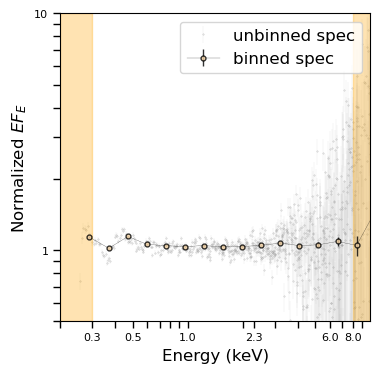

In [7]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))
spec_dir = './data/po'
cat = 'po'
warnings.filterwarnings('ignore',category=RuntimeWarning)

ene_ce,ratio_norm,ratio_err_norm,grpene_ce,grpratio_norm,grpratio_err_norm,Nsrc,norm_fac = get_ratio(spec_dir,cat)

ax1.errorbar(ene_ce,ratio_norm*ene_ce**2/16,yerr=(ratio_err_norm/2*ene_ce**2/16),
             fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5,label='unbinned spec')
ax1.errorbar(grpene_ce,grpratio_norm*grpene_ce**2/16,yerr=(grpratio_err_norm/2*grpene_ce**2/16),
             fmt='o-',ms=3.5,lw=0.20,c='k',capsize=0.,elinewidth=1.0,
             mec='k',mfc='#f9d7a7',alpha=0.8,zorder=1,label='binned spec')
# below 0.3 keV: too few sources; above 8.0 keV: bkg dominated
ax1.fill_betweenx(y=[0.5,10], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
ax1.fill_betweenx(y=[0.5,10], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 

ax1.legend(loc='upper right',fontsize=12)
ax1.set_xscale('log')
ax1.set_xlim(0.2,10)
x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([str(x) for x in x_ticks])
ax1.set_xlabel('Energy (keV)',fontsize=12)
ax1.tick_params("x",which="major",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.tick_params("x",which="minor",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.set_ylim(0.5,10)
ax1.set_yscale('log')
y_ticks = [1,10]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([str(y) for y in y_ticks])
ax1.set_ylabel(r'Normalized $EF_E$',fontsize=12)
ax1.tick_params("y",which="major",
                length=10,width = 1.0,size=5,labelsize=8)
ax1.tick_params("y",which="minor",
                length=10,width = 1.0,size=5,labelsize=8)

## **Step 4** (optional): Spectral fitting on other platform, e.g. XSPEC ... 

# **2. Other examples**
***Try for yourself!***

## **e.g.2**: absorbed powerlaw

The Galactic absorption is often an issue when studying the X-ray spectra of extragalactic sources (e.g. AGNs), suppressing the soft X-ray flux significantly.

<span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> allows for correction of Galactic absorption, in order to study the intrinsic spectral shape unaffected by the Galactic medium. This is essentially done by multiplying the observed-frame ARF (effective area vs. input energy) with Galactic absorption profile (absorption factor vs. input energy), as an approach to account for the expected loss of effective area due to the absorption effect. To activate this correction, you will need to specify the NH value of each spectrum (`nh_lst`), as well as the sample Galactic absorption profile (`nh_file`).

In [8]:
# fetch some basic data (they have already been generated)
pifile_lst = []
bkgpifile_lst = []
rmffile_lst = []
arffile_lst = []
z_lst = []
nh_lst = []

for i in range(200):
    pifile = './data/abspo/abspo_spec/%05d_abspo.pi'%i
    with fits.open(pifile) as hdu:
        head = hdu[1].header
    path = os.path.dirname(pifile)
    bkgpifile = os.path.join(path,head['BACKFILE'])
    rmffile = os.path.join(path,head['RESPFILE'])
    arffile = os.path.join(path,head['ANCRFILE'])
    zfile = os.path.join(path,head['ZFILE'])        # file storing redshift
    nhfile = os.path.join(path,head['NHFILE'])        # file storing NH
    with open(zfile,'r') as f:
        z = f.readlines()
    z = float(z[0].rstrip())
    with open(nhfile,'r') as f:
        nh = f.readlines()
    nh = float(nh[0].rstrip())

    pifile_lst.append(pifile)
    bkgpifile_lst.append(bkgpifile)
    rmffile_lst.append(rmffile)
    arffile_lst.append(arffile)
    z_lst.append(z)
    nh_lst.append(nh)

# run Xstack
XstackRunner(
    pifile_lst=pifile_lst,                          # PI file list
    arffile_lst=arffile_lst,                        # ARF file list
    rmffile_lst=rmffile_lst,                        # RMF file list
    z_lst=z_lst,                                    # redshift list
    bkgpifile_lst=bkgpifile_lst,                    # bkg PI file list
    nh_lst=nh_lst,                                  # nh list
    srcid_lst=np.arange(200),                       # source ID list (can be arbitary)
    rspwt_method="SHP",                             # method to calculate response weighting factor for each source (recommended: SHP)
    rspproj_gamma=2.0,                              # prior photon index for projecting RSP matrix onto the output energy channel
    int_rng=(1.0,2.3),                              # if `arfscal_method`=`SHP`, choose the range to calculate flux
    rmfsft_method='NONPAR',                         # method to shift RMF
    sample_rmf=None,                                # the sample RMF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    sample_arf=None,                                # the sample ARF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    nh_file=Xstack.default_nh_file,                 # the Galactic absorption profile (absorption factor vs. energy)
    Nbkggrp=10,                                     # the number of background groups to calculate uncertainty of background
    ene_trc=0.2,                                    # energy below which the ARF is manually truncated (e.g., 0.2 keV for eROSITA)
    rm_ene_dsp=True,                                # whether or not to remove the energy dispersion map
    usecpu=50,                                      # number of cpus used for RMF shifting
    o_pi_name='./data/abspo/abspo.pi',              # name of output PI spectrum file
    o_bkgpi_name='./data/abspo/abspo_bkg.pi',       # name of output background PI spectrum file
    o_arf_name='./data/abspo/abspo.arf',            # name of output ARF file
    o_rmf_name='./data/abspo/abspo.rmf',            # name of output RMF file
    o_fene_name='./data/abspo/abspo.fene',            # name of output fenergy file
).run()

#######################################################
################ Welcome to Xstack! ###################
#######################################################
This is the new version of Xstack: first combine ARF and RMF into RSP and then shift/stack!
****************** Input Check ... ********************
Number of sources: 200
Redshift range: 0.300 -- 1.995
NH range: 3.112857825192106e+18 -- 9.893400561666382e+20
NH file: /Users/chensj/software/installed/miniconda3/envs/Xstack/lib/python3.11/site-packages/Xstack/tbabs_1e20.txt
RSP weighting method: SHP
RSP projection gamma: 2.0
Flux calculation range: 1.0 -- 2.3 keV
ARF Truncation energy: 0.2 keV
RMF shifting method: NONPAR
Number of CPUs used for shifting RMF: 50
Number of background groups: 10
Output PI spectrum (base)name: ./data/abspo/abspo.pi
Output bkg PI spectrum (base)name: ./data/abspo/abspo_bkg.pi
Output ARF (base)name: ./data/abspo/abspo.arf
Output RMF (base)name: ./data/abspo/abspo.rmf
****************** Shifting 

100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


****************** Stacking ... ********************


100%|██████████| 200/200 [00:00<00:00, 207.97it/s]


[ 5.26762973e-03  1.12718365e-03  5.66589536e-02  3.71184105e-03
  4.77158148e-03  8.61155509e-03  5.78781158e-03  2.57344039e-03
  4.55188326e-03  3.29705578e-03  1.14330770e-03  2.02384334e-03
  2.03139388e-03  2.92401230e-04  7.91337067e-03  8.28227909e-05
  5.30954721e-04  2.62121763e-03  1.45356681e-02  1.73220011e-03
  5.57179219e-04  1.79269882e-04  8.97620978e-04  1.37037281e-03
  3.66772570e-04  1.44904312e-03  1.12239273e-02  3.27145506e-02
  1.04606389e-02  1.13298279e-03  7.23563295e-03  2.25475593e-03
 -6.52726121e-05  7.64208780e-04  5.47828105e-04  3.67845067e-03
  7.69467661e-04  2.81865549e-04  1.63341092e-02  1.31210694e-03
  2.59628722e-04  1.41653946e-03  2.84183947e-03  2.51741543e-04
  1.72160412e-02  2.27193238e-03  1.17030319e-04  2.27586822e-03
  3.92259881e-03  1.83172240e-02  5.64861899e-03  2.37896427e-03
  3.03208610e-03  9.79071739e-03  2.02964043e-03  2.75313228e-02
  7.55318166e-04  8.01087815e-03  5.89180206e-04  1.08064050e-03
  1.46414971e-02  3.44322

(array([ 0.,  0.,  0., ..., 19., 14.,  0.]),
 array([0.        , 0.        , 0.        , ..., 4.35889894, 3.74165739,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 20.09694816,
        20.76764488,  7.68905883]),
 array([0.        , 0.        , 0.        , ..., 0.6938237 , 0.7053062 ,
        0.42916141]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.02539426,
        30.78175219, 12.95096369]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.12311319, 0.1177131 ,
         0.05537153],
        [0.        , 0.        , 0.        , ..., 0.13784   , 0.14127881,
         0.06938217],
        [0.        , 0.        , 0.        , ..., 0.14364207, 0.152154

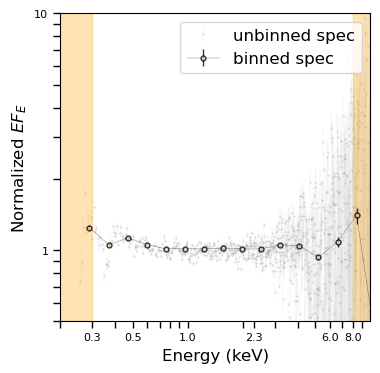

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))
spec_dir = './data/abspo'
cat = 'abspo'
warnings.filterwarnings('ignore',category=RuntimeWarning)

ene_ce,ratio_norm,ratio_err_norm,grpene_ce,grpratio_norm,grpratio_err_norm,Nsrc,norm_fac = get_ratio(spec_dir,cat)

ax1.errorbar(ene_ce,ratio_norm*ene_ce**2/16,yerr=(ratio_err_norm/2*ene_ce**2/16),
             fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5,label='unbinned spec')
ax1.errorbar(grpene_ce,grpratio_norm*grpene_ce**2/16,yerr=(grpratio_err_norm/2*grpene_ce**2/16),
             fmt='o-',ms=3.5,lw=0.20,c='k',capsize=0.,elinewidth=1.0,
             mec='k',mfc='#f9d7a7',alpha=0.8,zorder=1,label='binned spec')
# below 0.3 keV: too few sources; above 8.0 keV: bkg dominated
ax1.fill_betweenx(y=[0.5,10], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
ax1.fill_betweenx(y=[0.5,10], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 

ax1.legend(loc='upper right',fontsize=12)
ax1.set_xscale('log')
ax1.set_xlim(0.2,10)
x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([str(x) for x in x_ticks])
ax1.set_xlabel('Energy (keV)',fontsize=12)
ax1.tick_params("x",which="major",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.tick_params("x",which="minor",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.set_ylim(0.5,10)
ax1.set_yscale('log')
y_ticks = [1,10]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([str(y) for y in y_ticks])
ax1.set_ylabel(r'Normalized $EF_E$',fontsize=12)
ax1.tick_params("y",which="major",
                length=10,width = 1.0,size=5,labelsize=8)
ax1.tick_params("y",which="minor",
                length=10,width = 1.0,size=5,labelsize=8)

## **e.g.3**: primary continuum (powerlaw) + soft excess (bbody)

In [11]:
# fetch some basic data (they have already been generated)
pifile_lst = []
bkgpifile_lst = []
rmffile_lst = []
arffile_lst = []
z_lst = []
nh_lst = []

for i in range(200):
    pifile = './data/pobb/pobb_spec/%05d_pobb.pi'%i
    with fits.open(pifile) as hdu:
        head = hdu[1].header
    path = os.path.dirname(pifile)
    bkgpifile = os.path.join(path,head['BACKFILE'])
    rmffile = os.path.join(path,head['RESPFILE'])
    arffile = os.path.join(path,head['ANCRFILE'])
    zfile = os.path.join(path,head['ZFILE'])        # file storing redshift
    with open(zfile,'r') as f:
        z = f.readlines()
    z = float(z[0].rstrip())

    pifile_lst.append(pifile)
    bkgpifile_lst.append(bkgpifile)
    rmffile_lst.append(rmffile)
    arffile_lst.append(arffile)
    z_lst.append(z)

# run Xstack
XstackRunner(
    pifile_lst=pifile_lst,                          # PI file list
    arffile_lst=arffile_lst,                        # ARF file list
    rmffile_lst=rmffile_lst,                        # RMF file list
    z_lst=z_lst,                                    # redshift list
    bkgpifile_lst=bkgpifile_lst,                    # bkg PI file list
    srcid_lst=np.arange(200),                       # source ID list (can be arbitary)
    rspwt_method="SHP",                             # method to calculate response weighting factor for each source (recommended: SHP)
    rspproj_gamma=2.0,                              # prior photon index for projecting RSP matrix onto the output energy channel
    int_rng=(1.0,2.3),                              # if `arfscal_method`=`SHP`, choose the range to calculate flux
    rmfsft_method='NONPAR',                         # method to shift RMF
    sample_rmf=None,                                # the sample RMF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    sample_arf=None,                                # the sample ARF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    Nbkggrp=10,                                     # the number of background groups to calculate uncertainty of background
    ene_trc=0.2,                                    # energy below which the ARF is manually truncated (e.g., 0.2 keV for eROSITA)
    rm_ene_dsp=True,                                # whether or not to remove the energy dispersion map
    usecpu=50,                                      # number of cpus used for RMF shifting
    o_pi_name='./data/pobb/pobb.pi',              # name of output PI spectrum file
    o_bkgpi_name='./data/pobb/pobb_bkg.pi',       # name of output background PI spectrum file
    o_arf_name='./data/pobb/pobb.arf',            # name of output ARF file
    o_rmf_name='./data/pobb/pobb.rmf',            # name of output RMF file
    o_fene_name='./data/pobb/pobb.fene',            # name of output fenergy file
).run()

#######################################################
################ Welcome to Xstack! ###################
#######################################################
This is the new version of Xstack: first combine ARF and RMF into RSP and then shift/stack!
****************** Input Check ... ********************
Number of sources: 200
Redshift range: 0.300 -- 1.995
NH range: 0.0 -- 0.0
NH file: None
RSP weighting method: SHP
RSP projection gamma: 2.0
Flux calculation range: 1.0 -- 2.3 keV
ARF Truncation energy: 0.2 keV
RMF shifting method: NONPAR
Number of CPUs used for shifting RMF: 50
Number of background groups: 10
Output PI spectrum (base)name: ./data/pobb/pobb.pi
Output bkg PI spectrum (base)name: ./data/pobb/pobb_bkg.pi
Output ARF (base)name: ./data/pobb/pobb.arf
Output RMF (base)name: ./data/pobb/pobb.rmf
****************** Shifting ... ********************


100%|██████████| 200/200 [00:24<00:00,  8.24it/s]


****************** Stacking ... ********************


100%|██████████| 200/200 [00:00<00:00, 210.24it/s]


[4.43936224e-03 8.50454385e-04 6.01982425e-02 3.31302527e-03
 4.72343779e-03 8.45526157e-03 5.77310894e-03 2.33471490e-03
 4.67774134e-03 3.04951602e-03 1.16701891e-03 2.03921707e-03
 2.01219231e-03 1.73588770e-04 6.52779922e-03 6.76341423e-04
 6.59678669e-04 3.01524996e-03 1.28140675e-02 1.48496611e-03
 3.98066798e-04 1.15626187e-04 1.05445689e-03 1.72184086e-03
 3.49956361e-04 1.50215386e-03 1.18747135e-02 3.37839410e-02
 1.11328224e-02 1.12959948e-03 8.16753672e-03 2.18789163e-03
 7.12712101e-04 8.00624928e-04 6.35189922e-04 3.47079901e-03
 3.26685750e-04 6.85607284e-04 1.55323142e-02 1.31148877e-03
 1.84077608e-04 1.75361464e-03 3.29303633e-03 3.16255363e-04
 1.57838530e-02 1.71573389e-03 9.78390676e-05 1.98122125e-03
 4.15126115e-03 1.85070013e-02 5.90427399e-03 2.15289685e-03
 2.85920122e-03 8.29299327e-03 1.69129119e-03 2.68820950e-02
 1.01029617e-03 7.89068049e-03 6.65169198e-04 8.80679577e-04
 1.53913253e-02 3.55706792e-03 1.16833450e-03 3.02612439e-03
 2.95880195e-02 9.497120

(array([ 0.,  0.,  0., ..., 16., 17.,  0.]),
 array([0.        , 0.        , 0.        , ..., 4.        , 4.12310563,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 20.38438961,
        21.10299324,  8.55138319]),
 array([0.        , 0.        , 0.        , ..., 0.69876788, 0.71097791,
        0.45258719]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.90296051,
        31.6558831 , 13.55240883]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.12255845, 0.11727783,
         0.05429975],
        [0.        , 0.        , 0.        , ..., 0.1371777 , 0.14058447,
         0.06794229],
        [0.        , 0.        , 0.        , ..., 0.14265354, 0.151025

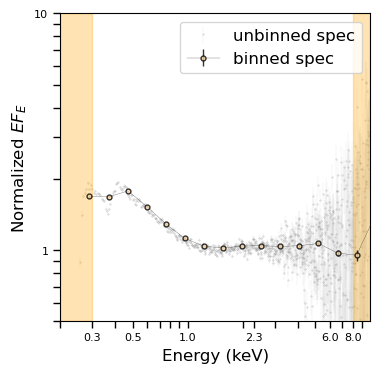

In [12]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))
spec_dir = './data/pobb'
cat = 'pobb'
warnings.filterwarnings('ignore',category=RuntimeWarning)

ene_ce,ratio_norm,ratio_err_norm,grpene_ce,grpratio_norm,grpratio_err_norm,Nsrc,norm_fac = get_ratio(spec_dir,cat)

ax1.errorbar(ene_ce,ratio_norm*ene_ce**2/16,yerr=(ratio_err_norm/2*ene_ce**2/16),
             fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5,label='unbinned spec')
ax1.errorbar(grpene_ce,grpratio_norm*grpene_ce**2/16,yerr=(grpratio_err_norm/2*grpene_ce**2/16),
             fmt='o-',ms=3.5,lw=0.20,c='k',capsize=0.,elinewidth=1.0,
             mec='k',mfc='#f9d7a7',alpha=0.8,zorder=1,label='binned spec')
# below 0.3 keV: too few sources; above 8.0 keV: bkg dominated
ax1.fill_betweenx(y=[0.5,10], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
ax1.fill_betweenx(y=[0.5,10], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 

ax1.legend(loc='upper right',fontsize=12)
ax1.set_xscale('log')
ax1.set_xlim(0.2,10)
x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([str(x) for x in x_ticks])
ax1.set_xlabel('Energy (keV)',fontsize=12)
ax1.tick_params("x",which="major",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.tick_params("x",which="minor",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.set_ylim(0.5,10)
ax1.set_yscale('log')
y_ticks = [1,10]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([str(y) for y in y_ticks])
ax1.set_ylabel(r'Normalized $EF_E$',fontsize=12)
ax1.tick_params("y",which="major",
                length=10,width = 1.0,size=5,labelsize=8)
ax1.tick_params("y",which="minor",
                length=10,width = 1.0,size=5,labelsize=8)

## **e.g.4**: absorbed primary continuum (powerlaw) + soft excess (bbody)

In [13]:
# fetch some basic data (they have already been generated)
pifile_lst = []
bkgpifile_lst = []
rmffile_lst = []
arffile_lst = []
z_lst = []
nh_lst = []

for i in range(200):
    pifile = './data/abspobb/abspobb_spec/%05d_abspobb.pi'%i
    with fits.open(pifile) as hdu:
        head = hdu[1].header
    path = os.path.dirname(pifile)
    bkgpifile = os.path.join(path,head['BACKFILE'])
    rmffile = os.path.join(path,head['RESPFILE'])
    arffile = os.path.join(path,head['ANCRFILE'])
    zfile = os.path.join(path,head['ZFILE'])        # file storing redshift
    nhfile = os.path.join(path,head['NHFILE'])        # file storing NH
    with open(zfile,'r') as f:
        z = f.readlines()
    z = float(z[0].rstrip())
    with open(nhfile,'r') as f:
        nh = f.readlines()
    nh = float(nh[0].rstrip())

    pifile_lst.append(pifile)
    bkgpifile_lst.append(bkgpifile)
    rmffile_lst.append(rmffile)
    arffile_lst.append(arffile)
    z_lst.append(z)
    nh_lst.append(nh)

# run Xstack
XstackRunner(
    pifile_lst=pifile_lst,                          # PI file list
    arffile_lst=arffile_lst,                        # ARF file list
    rmffile_lst=rmffile_lst,                        # RMF file list
    z_lst=z_lst,                                    # redshift list
    bkgpifile_lst=bkgpifile_lst,                    # bkg PI file list
    nh_lst=nh_lst,                                  # nh list
    srcid_lst=np.arange(200),                       # source ID list (can be arbitary)
    rspwt_method="SHP",                             # method to calculate response weighting factor for each source (recommended: SHP)
    rspproj_gamma=2.0,                              # prior photon index for projecting RSP matrix onto the output energy channel
    int_rng=(1.0,2.3),                              # if `arfscal_method`=`SHP`, choose the range to calculate flux
    rmfsft_method='NONPAR',                         # method to shift RMF
    sample_rmf=None,                                # the sample RMF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    sample_arf=None,                                # the sample ARF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
    nh_file=Xstack.default_nh_file,                 # the Galactic absorption profile (absorption factor vs. energy)
    Nbkggrp=10,                                     # the number of background groups to calculate uncertainty of background
    ene_trc=0.2,                                    # energy below which the ARF is manually truncated (e.g., 0.2 keV for eROSITA)
    rm_ene_dsp=True,                                # whether or not to remove the energy dispersion map
    usecpu=50,                                      # number of cpus used for RMF shifting
    o_pi_name='./data/abspobb/abspobb.pi',              # name of output PI spectrum file
    o_bkgpi_name='./data/abspobb/abspobb_bkg.pi',       # name of output background PI spectrum file
    o_arf_name='./data/abspobb/abspobb.arf',            # name of output ARF file
    o_rmf_name='./data/abspobb/abspobb.rmf',            # name of output RMF file
    o_fene_name='./data/abspobb/abspobb.fene',            # name of output fenergy file
).run()

#######################################################
################ Welcome to Xstack! ###################
#######################################################
This is the new version of Xstack: first combine ARF and RMF into RSP and then shift/stack!
****************** Input Check ... ********************
Number of sources: 200
Redshift range: 0.300 -- 1.995
NH range: 3.112857825192106e+18 -- 9.893400561666382e+20
NH file: /Users/chensj/software/installed/miniconda3/envs/Xstack/lib/python3.11/site-packages/Xstack/tbabs_1e20.txt
RSP weighting method: SHP
RSP projection gamma: 2.0
Flux calculation range: 1.0 -- 2.3 keV
ARF Truncation energy: 0.2 keV
RMF shifting method: NONPAR
Number of CPUs used for shifting RMF: 50
Number of background groups: 10
Output PI spectrum (base)name: ./data/abspobb/abspobb.pi
Output bkg PI spectrum (base)name: ./data/abspobb/abspobb_bkg.pi
Output ARF (base)name: ./data/abspobb/abspobb.arf
Output RMF (base)name: ./data/abspobb/abspobb.rmf
************

100%|██████████| 200/200 [00:23<00:00,  8.56it/s]


****************** Stacking ... ********************


100%|██████████| 200/200 [00:00<00:00, 202.74it/s]


[ 4.55892147e-03  8.88698551e-04  6.18533939e-02  3.39321351e-03
  4.66088237e-03  8.52738599e-03  6.33506992e-03  2.75183151e-03
  5.00043524e-03  3.06344242e-03  1.25608851e-03  2.01026097e-03
  2.05030237e-03  2.06800680e-04  6.58160315e-03  3.67313789e-04
  6.48796097e-04  2.97978804e-03  1.34799972e-02  1.55613090e-03
  3.32183803e-04  1.45742353e-04  1.15988639e-03  1.66731981e-03
  3.43929897e-04  1.65594841e-03  1.15944665e-02  3.21936435e-02
  1.07092300e-02  1.19263172e-03  8.36592169e-03  2.03161286e-03
  2.66105680e-04  8.15845023e-04  6.18297824e-04  3.62510113e-03
  3.83561613e-04  4.90516755e-04  1.56080218e-02  1.30409915e-03
  2.22392275e-04  1.80750371e-03  3.10114109e-03  2.90603826e-04
  1.58565304e-02  1.80954309e-03  1.16299914e-04  1.98362518e-03
  4.01965781e-03  1.84616458e-02  5.75296645e-03  2.27868239e-03
  3.03730482e-03  8.58191351e-03  1.89641295e-03  2.76487711e-02
  9.53396368e-04  8.03348900e-03  5.89116988e-04  1.00315257e-03
  1.56574015e-02  3.46664

(array([ 0.,  0.,  0., ..., 11., 21.,  0.]),
 array([0.        , 0.        , 0.        , ..., 3.31662479, 4.58257569,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 19.85741362,
        21.1269467 ,  8.38370901]),
 array([0.        , 0.        , 0.        , ..., 0.68967648, 0.7113813 ,
        0.4481281 ]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.35233195,
        31.10755957, 13.19282201]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.12287388, 0.11752579,
         0.05478885],
        [0.        , 0.        , 0.        , ..., 0.13755555, 0.14098075,
         0.06861925],
        [0.        , 0.        , 0.        , ..., 0.14326102, 0.151733

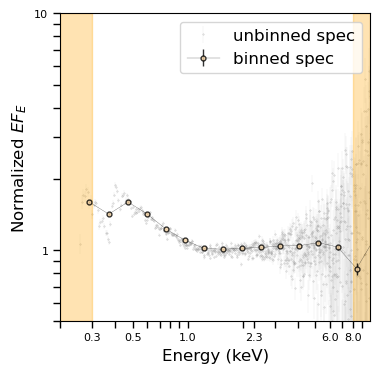

In [14]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))
spec_dir = './data/abspobb'
cat = 'abspobb'
warnings.filterwarnings('ignore',category=RuntimeWarning)

ene_ce,ratio_norm,ratio_err_norm,grpene_ce,grpratio_norm,grpratio_err_norm,Nsrc,norm_fac = get_ratio(spec_dir,cat)

ax1.errorbar(ene_ce,ratio_norm*ene_ce**2/16,yerr=(ratio_err_norm/2*ene_ce**2/16),
             fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5,label='unbinned spec')
ax1.errorbar(grpene_ce,grpratio_norm*grpene_ce**2/16,yerr=(grpratio_err_norm/2*grpene_ce**2/16),
             fmt='o-',ms=3.5,lw=0.20,c='k',capsize=0.,elinewidth=1.0,
             mec='k',mfc='#f9d7a7',alpha=0.8,zorder=1,label='binned spec')
# below 0.3 keV: too few sources; above 8.0 keV: bkg dominated
ax1.fill_betweenx(y=[0.5,10], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
ax1.fill_betweenx(y=[0.5,10], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 

ax1.legend(loc='upper right',fontsize=12)
ax1.set_xscale('log')
ax1.set_xlim(0.2,10)
x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([str(x) for x in x_ticks])
ax1.set_xlabel('Energy (keV)',fontsize=12)
ax1.tick_params("x",which="major",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.tick_params("x",which="minor",
                length=10,width = 1.0,size=5,labelsize=8,pad=3)
ax1.set_ylim(0.5,10)
ax1.set_yscale('log')
y_ticks = [1,10]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([str(y) for y in y_ticks])
ax1.set_ylabel(r'Normalized $EF_E$',fontsize=12)
ax1.tick_params("y",which="major",
                length=10,width = 1.0,size=5,labelsize=8)
ax1.tick_params("y",which="minor",
                length=10,width = 1.0,size=5,labelsize=8)

# **3. (optional) Generate some fake spectra**

## single powerlaws

In [24]:
# subprocess.run(['python', './generate_scripts/generate_po.py'],stdin=devnull) # gives wrong HEADER
!python ./generate_scripts/generate_po.py

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 44.01it/s]


## single absorbed powerlaw

In [7]:
!python ./generate_scripts/generate_abspo.py

100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 34.30it/s]


## primary continuum (powerlaw) + soft excess (bbody)

In [17]:
!python ./generate_scripts/generate_pobb.py

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 46.13it/s]


## absorbed primary continuum (powerlaw) + soft excess (bbody)

In [20]:
!python ./generate_scripts/generate_abspobb.py

100%|█████████████████████████████████████████| 200/200 [00:07<00:00, 26.48it/s]
